In [1]:
from datasets import load_cifar10
from models.resnet import resnet50
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = resnet50("cifar10")
from fvw_method import exp

In [2]:
train_dataloader, test_dataloader, data_min, data_max = load_cifar10()

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class FGSM:
    def __init__(self, epsilon, data_min, data_max):
        self.epsilon = epsilon
        self.criterion = nn.CrossEntropyLoss()
        self.data_min = data_min
        self.data_max = data_max

    def __call__(self, model, data, target, num_steps=50, alpha=0.001):
        dt = data.clone().detach().requires_grad_(True)
        for _ in range(num_steps):
            output = model(dt)
            if output.argmax() != target:
                break
            loss = self.criterion(output, target)
            loss.backward()
            dt.data = dt.data + alpha * dt.grad.data.sign()
            dt.data = torch.clamp(dt.data, self.data_min, self.data_max)
            dt.grad.data.zero_()
        return dt, output.argmax() != target
    

In [32]:
def attack_picture(model, data, target, attack, num_steps=50, alpha=0.001):
    data, target = data.to(device), target.to(device)
    data, target = data.unsqueeze(0), target.unsqueeze(0)
    dt, success = attack(model, data, target, num_steps, alpha)
    if success:
        fig,axes = plt.subplots(1,2)
        axes[0].bar(range(10), F.softmax(model(data), dim=1).squeeze().detach().cpu().numpy())
        axes[0].set_title("Original")
        axes[0].set_xticks(range(10))
        axes[1].bar(range(10), F.softmax(model(dt), dim=1).squeeze().detach().cpu().numpy())
        axes[1].set_title("Adversarial")
        axes[1].set_xticks(range(10))
        plt.show()
    else:
        print("Attack failed")
    return dt.squeeze(0), success

In [33]:
fgsm = FGSM(epsilon=0.001, data_min=data_min, data_max=data_max)

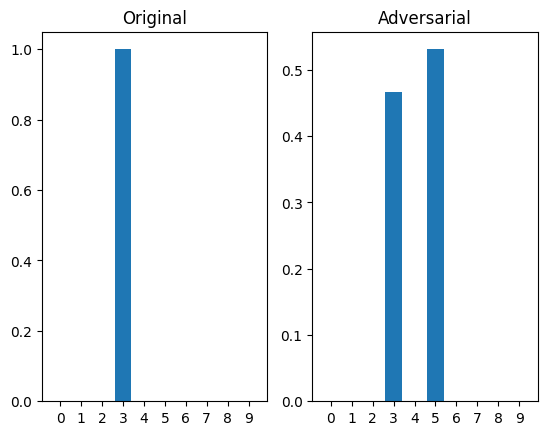

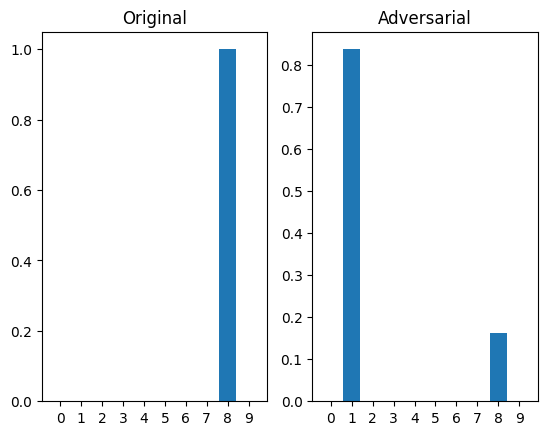

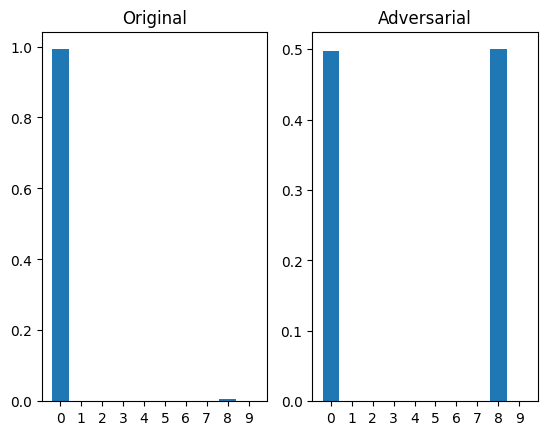

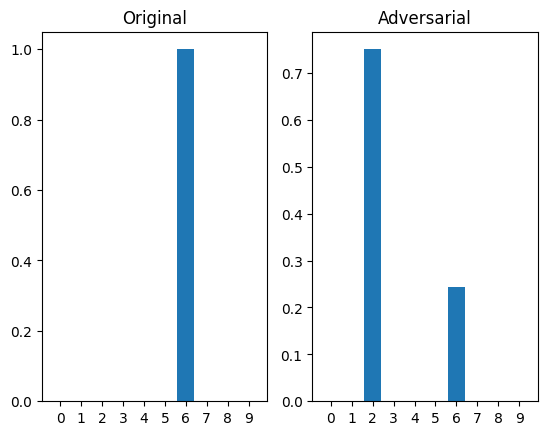

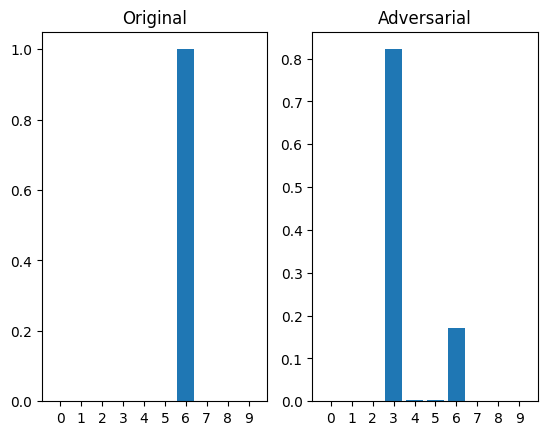

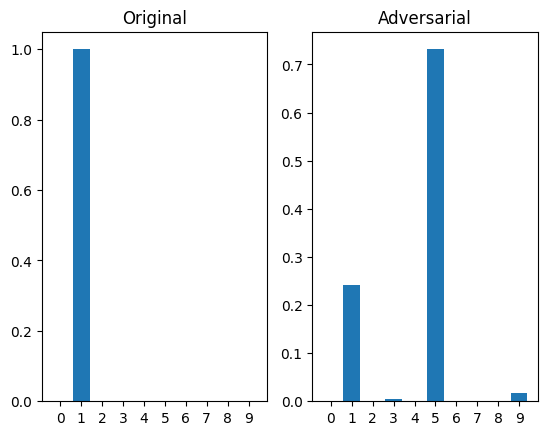

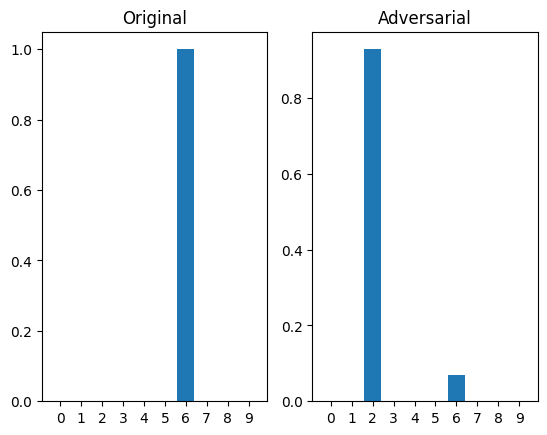

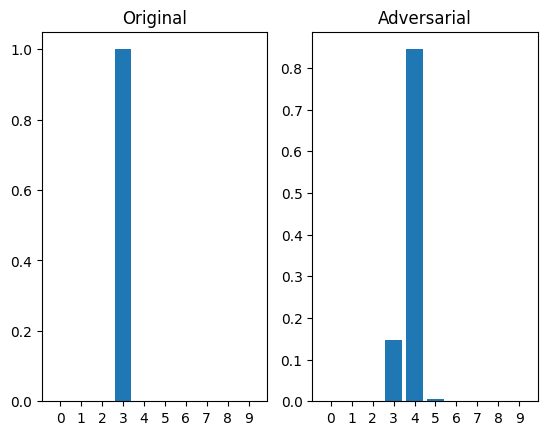

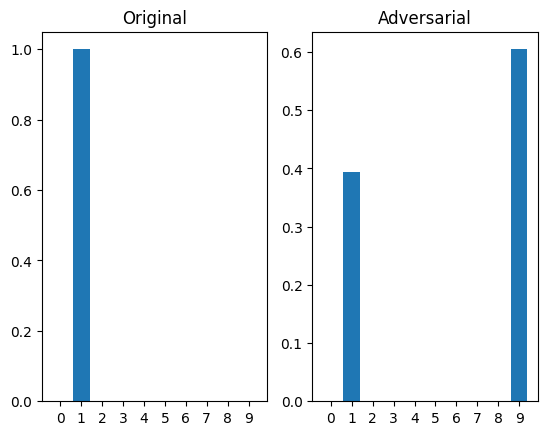

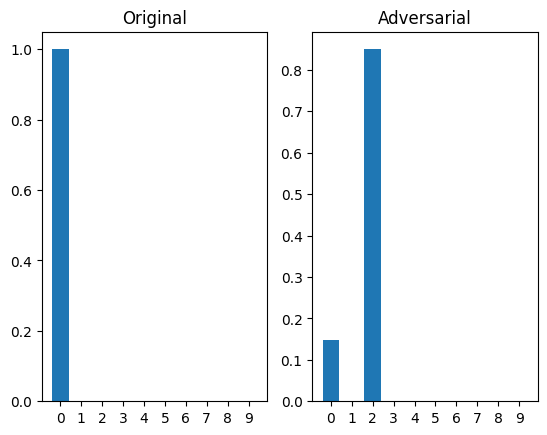

In [35]:
for x, label in test_dataloader:
    x, label = x.to(device), label.to(device)
    pred = model(x)
    correct = pred.argmax(-1) == label
    x = x[correct]
    label = label[correct]
    for i in range(10):
        attack_picture(model, x[i], label[i], fgsm)
        # break
    break